In [ ]:
!pip install pytorch_lightning
!pip install torcheval
!pip install torch-fidelity

In [3]:
import cv2
import os
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import torch
import matplotlib.pyplot as plt
from PIL import Image

/home/mashalimay/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Globals

In [46]:
# Directories with images to evaluate
orig_imgs_dir = 'data/original'
experiments1_dir = 'data/experiments1/'  # Aggregated Attention
experiments2_dir = 'data/experiments2/'  # Scene-Based
sd_baseline_dir = 'data/sd_baseline/'

categories = {
    'Airplane',
    'Animal',
    'Automobile',
}

categories_scenes = {
    'Airplane': {'Cloud', 'Runway'},
    'Animal': {'Beach', 'Desert', 'Forest'},
    'Automobile': {'City', 'Highway'},
} 


## Auxiliary Functions

In [72]:
def load_original_images(orig_imgs_dir):
    orig_imgs = {}
    for category in categories:
        orig_imgs[category] = []
        dir_path = os.path.join(orig_imgs_dir, category)
        # loop over all images in the directory
        img_names = sorted(os.listdir(dir_path))
        for img_name in img_names:
            img_path = os.path.join(dir_path, img_name)  
            img = cv2.imread(img_path)
            # img = Image.open(img_path)
            orig_imgs[category].append(img)
            
    return orig_imgs, img_names

def load_experiment_images(experiment_dir):
    experiment_imgs = {}
    for category in categories:
        experiment_imgs[category] = {}
        for scene in categories_scenes[category]:
            experiment_imgs[category][scene] = []
            dir_path = os.path.join(experiment_dir, category, scene)
            for img_name in sorted(os.listdir(dir_path)):
                img = cv2.imread(os.path.join(experiment_dir, category, scene, img_name))
                # img = Image.open(os.path.join(experiment_dir, category, scene, img_name))
                experiment_imgs[category][scene].append(img)
    return experiment_imgs

def show_img(img, save_path=None):
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        # save with cv2 to avoid changes in the image
        cv2.imwrite(save_path, img)
    
    # Get image dimensions
    height, width, depth = img.shape

    # Set DPI and calculate figure size in inches
    dpi = 100  
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure with the specified size and DPI
    plt.figure(figsize=figsize, dpi=dpi)

    # Display image in notebook
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
    plt.axis('off') 

    
    plt.show()
    plt.close()


def imgs_compare(orig_imgs: list, experiment_imgs, index: int, category, scene, show=True, save_dir=None,
                 experiment_names = ['Stable Diffusion','Aggregated Attention', 'Scene-Based'],
                 img_names = None):

    original_img = orig_imgs[category][index]
    experiment_imgs = [expt_imgs[category][scene][index] for expt_imgs in experiment_imgs]
    all_imgs = [original_img] + experiment_imgs

    # Target sizes for resizing
    target_height = min([img.shape[0] for img in all_imgs])
    target_width = min(img.shape[1] for img in [original_img] + experiment_imgs)
    target_size = (target_width, target_height)

    # Resize images to common size
    original_img_resized = cv2.resize(original_img, target_size, interpolation=cv2.INTER_AREA)
    experiment_imgs_resized = [cv2.resize(img, target_size, interpolation=cv2.INTER_AREA) for img in experiment_imgs]

    # Create a figure to display the images
    fig, axs = plt.subplots(1, len(experiment_imgs_resized) + 1, figsize=(20, 20)) 

    # Display original image
    axs[0].imshow(cv2.cvtColor(original_img_resized, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[0].axis('off')

    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

    # Display experimental images
    for i, img in enumerate(experiment_imgs_resized):
        axs[i + 1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i + 1].set_title(experiment_names[i])
        axs[i + 1].axis('off') 

    # Save subplot to file
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        img_name = img_names[index] if img_names else index
        plt.savefig(os.path.join(save_dir, f'{img_name}.png'), bbox_inches='tight', pad_inches=0.1)

    if show:
        plt.show() 
    plt.close(fig)  

### Scoring functions

In [4]:
# Define a function to calculate Inception Score (IS)
def get_is_score(images):
    images = np.transpose(images, (0, 3, 1, 2))  # Channels-last to channels-first
    images = torch.tensor(images, dtype=torch.uint8)  # Convert to torch tensor

    # Initialize InceptionScore metric
    is_metric = InceptionScore(feature=2048)  # Using default feature extraction
    is_metric.update(images)  # Update metric with generated images
    is_score = is_metric.compute()  # Compute Inception Score

    return is_score[0].item(), is_score[1].item()  # Return mean and standard deviation

# Define a function to calculate FID score
def get_fid_score(images1, images2):
    images1 = torch.tensor(images1, dtype=torch.uint8)
    images2 = torch.tensor(images2, dtype=torch.uint8)

    # Add batch dimension
    images1 = images1.unsqueeze(0)
    images2 = images2.unsqueeze(0)

    # Batch_size * C * H * W -> Batch_size * H * W * C
    images1 = images1.permute(0, 3, 1, 2)
    images2 = images2.permute(0, 3, 1, 2)

    # Repeat images for FID calculation
    images1 = images1.repeat(2, 1, 1, 1)
    images2 = images2.repeat(2, 1, 1, 1)

    # Initialize FID metric
    fid = FrechetInceptionDistance(feature=64)
    fid.update(images1, real=True)
    fid.update(images2, real=False)
    fid_score = fid.compute()
    return fid_score.item()

## Load and Visualize Images

In [48]:
orig_imgs, img_names = load_original_images(orig_imgs_dir)
imgs1 = load_experiment_images(experiments1_dir)  # Aggregated Attention
imgs2 = load_experiment_images(experiments2_dir)  # Scene-Based
sd_base = load_experiment_images(sd_baseline_dir)

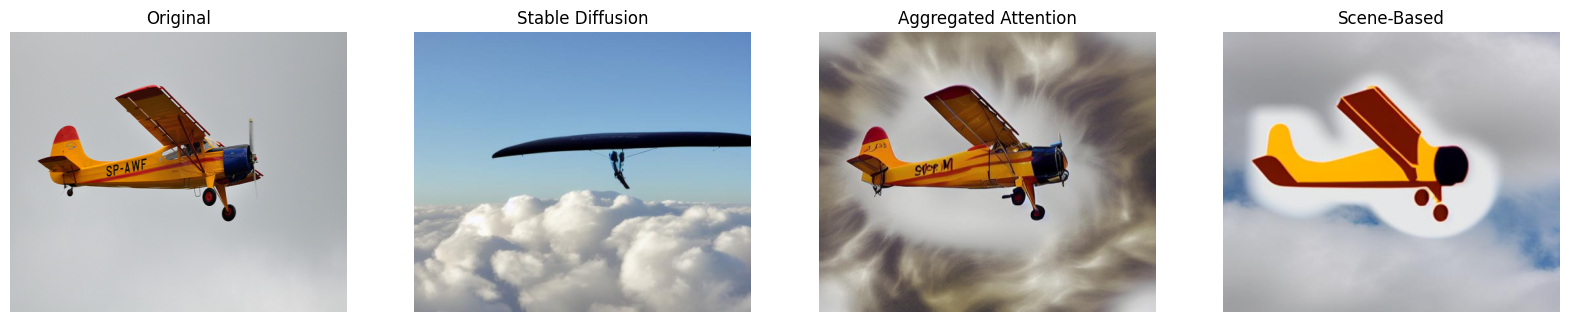

In [73]:
category = 'Airplane'
scene = 'Cloud'
idx = 2
imgs_compare(orig_imgs=orig_imgs, experiment_imgs=[sd_base, imgs1, imgs2], index=idx, show=True,
             experiment_names=['Stable Diffusion','Aggregated Attention', 'Scene-Based'],
            category='Airplane', scene='Cloud', save_dir = f'./results/imgs_compared/{category}/{scene}', 
            img_names=img_names)

KeyboardInterrupt: 

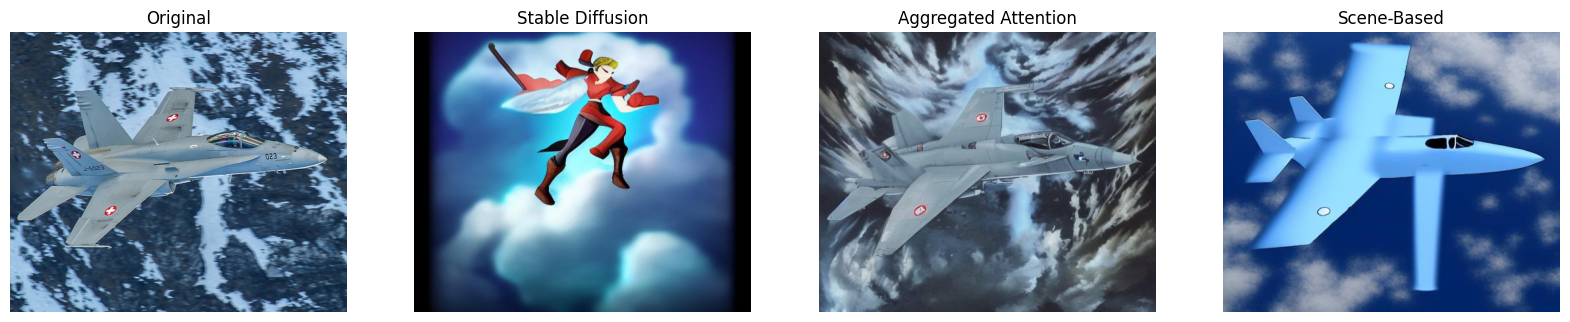

In [65]:
for category in categories:
    for scene in categories_scenes[category]:
        for idx, img_name in enumerate(img_names):
            imgs_compare(orig_imgs=orig_imgs, experiment_imgs=[sd_base, imgs1, imgs2], index=idx, show=False,
                         experiment_names=['Stable Diffusion','Aggregated Attention', 'Scene-Based'],
                        category=category, scene=scene, save_dir = f'./results/imgs_compared/{img_names[idx]}')

In [ ]:
import json
import os
from PIL import Image

# Load JSON data
with open('./Dataset_DL_7643/dataset.json', 'r') as json_file:
    data = json.load(json_file)

# List to store images
images = []

# Loop through each entry in JSON and open images
for entry in data:
    image_path = os.path.join('Dataset_DL_7643', entry['image_path'])
    print(image_path)
    image = Image.open(image_path)
    images.append(image)

# Get the dimensions of the images
width, height = images[0].size

# Calculate the number of rows and columns
num_rows = 6
num_cols = 5
total_images = len(images)

# Calculate the dimensions of the combined image
combined_width = width * num_cols
combined_height = height * num_rows

# Create a new blank image to accommodate all images
combined_image = Image.new('RGB', (combined_width, combined_height))

# Paste each image into the combined image
for i, img in enumerate(images):
    row = i // num_cols
    col = i % num_cols
    combined_image.paste(img, (col * width, row * height))

# Save or display the combined image
combined_image.save('combined_image.jpg')


In [ ]:
import cv2
import os

# Define the directory where your images are stored
base_dir = "generated_images"

# List all the categories
categories = ["Airplane", "Animal", "Automobile"]

# Loop through each category
for category in categories:
    # Create a list to store combined images for each scene
    scene_combined_images = []

    # List all the scenes in the category directory
    scenes = os.listdir(os.path.join(base_dir, category))

    # Loop through each scene
    for scene in scenes:
        # List all the images in the scene directory
        images = os.listdir(os.path.join(base_dir, category, scene))

        # Create a list to store images for this scene
        scene_images = []

        # Loop through each image in the scene
        for image in images:
            image_path = os.path.join(base_dir, category, scene, image)
            scene_images.append(cv2.imread(image_path))

        # Concatenate images in the scene horizontally
        scene_combined_horizontal = cv2.hconcat(scene_images)

        # Add the horizontally combined image to the list
        scene_combined_images.append(scene_combined_horizontal)

    # Concatenate images for all scenes vertically
    combined_image = cv2.vconcat(scene_combined_images)

    # Display or save the combined image
    cv2.imshow(category, combined_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite(category + "_combined.jpg", combined_image)


In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow

# Define the directory where your images are stored
base_dir = "generated_images"

# List all the categories
categories = ["Airplane", "Animal", "Automobile"]

# Loop through each category
for category in categories:
    # Create a list to store combined images for each scene
    scene_combined_images = []

    # List all the scenes in the category directory
    scenes = os.listdir(os.path.join(base_dir, category))

    # Loop through each scene
    for scene in scenes:
        # List all the images in the scene directory
        images = os.listdir(os.path.join(base_dir, category, scene))

        # Create a list to store images for this scene
        scene_images = []

        # Loop through each image in the scene
        for image in images:
            image_path = os.path.join(base_dir, category, scene, image)
            scene_images.append(cv2.imread(image_path))

        # Concatenate images in the scene horizontally
        scene_combined_horizontal = cv2.hconcat(scene_images)

        # Add the horizontally combined image to the list
        scene_combined_images.append(scene_combined_horizontal)

    # Concatenate images for all scenes vertically
    combined_image = cv2.vconcat(scene_combined_images)

    # Display or save the combined image
    cv2_imshow(combined_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite(category + "_combined.jpg", combined_image)


In [ ]:
import cv2
import os

# Define the directory where your images are stored
base_dir = "generated_image"

# List all the categories
categories = ["Airplane", "Animal", "Automobile"]

# Create a list to store all combined images for each category
all_combined_images = []

# Loop through each category
for category in categories:
    # Create a list to store combined images for each scene
    scene_combined_images = []

    # List all the scenes in the category directory
    scenes = os.listdir(os.path.join(base_dir, category))

    # Loop through each scene
    for scene in scenes:
        # List all the images in the scene directory
        images = os.listdir(os.path.join(base_dir, category, scene))

        # Create a list to store images for this scene
        scene_images = []

        # Loop through each image in the scene
        for image in images:
            image_path = os.path.join(base_dir, category, scene, image)
            scene_images.append(cv2.imread(image_path))

        # Concatenate images in the scene horizontally
        scene_combined_horizontal = cv2.hconcat(scene_images)

        # Add the horizontally combined image to the list
        scene_combined_images.append(scene_combined_horizontal)

    # Concatenate images for all scenes vertically
    category_combined_image = cv2.vconcat(scene_combined_images)

    # Add the category combined image to the list
    all_combined_images.append(category_combined_image)

# Concatenate all category combined images vertically
final_combined_image = cv2.vconcat(all_combined_images)

# Display or save the final combined image
cv2_imshow(final_combined_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("final_combined_image.jpg", final_combined_image)
